# Predict Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE scores (test)
- GPA scores (grades)
- Class rank (1-4)
    
The dataset originally came from here: http://www.ats.ucla.edu/

## Load the Data
To load the data and format it nicely, we will use two very useful packages called Pandas and NumPy. You can read their documentation:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plot the Data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

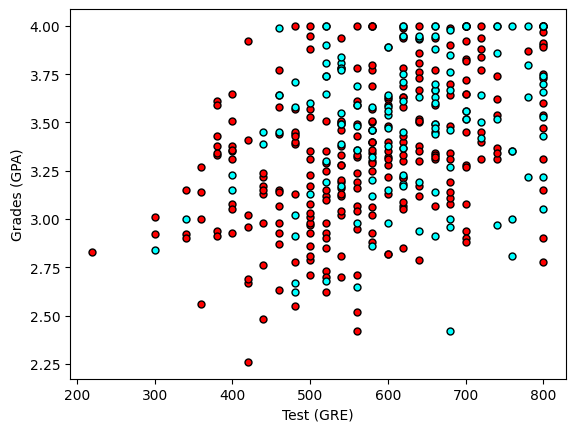

In [ ]:
# Importing matplotlib
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre", "gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s=25, color='red', edgecolor='k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s=25, color='cyan', edgecolor='k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')

# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

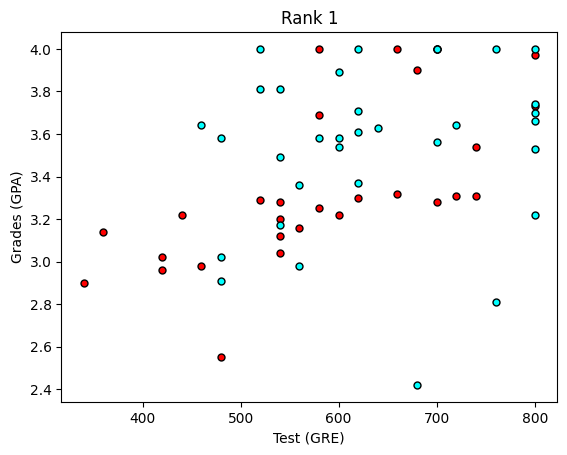

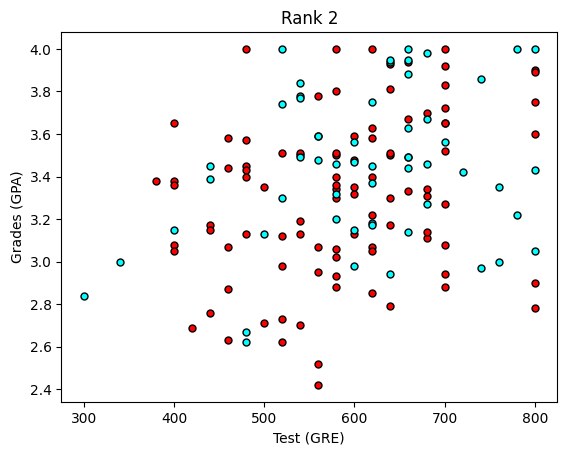

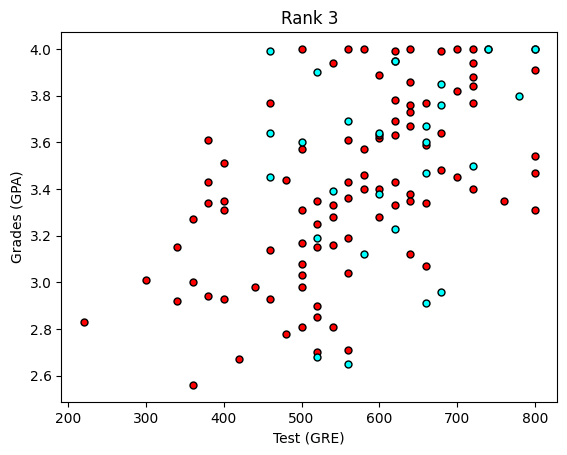

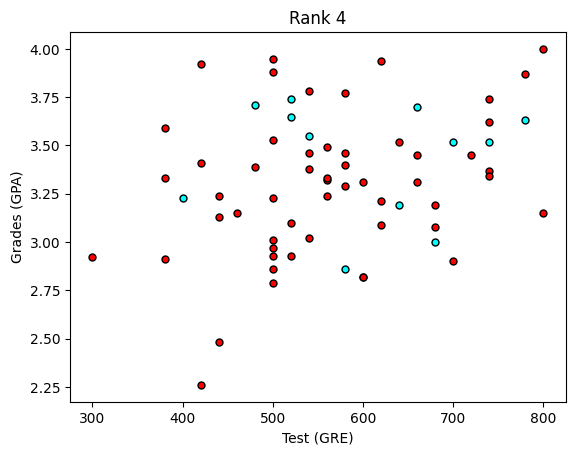

In [3]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use rank as one of our inputs. To do this, we should one-hot encode it.

## TODO: One-Hot Encode the Rank
Use the `get_dummies` function in Pandas in order to one-hot encode the data.

In [4]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,False,False,True,False
1,1,660,3.67,False,False,True,False
2,1,800,4.00,True,False,False,False
3,1,640,3.19,False,False,False,True
4,0,520,2.93,False,False,False,True
5,1,760,3.00,False,True,False,False
6,1,560,2.98,True,False,False,False
7,0,400,3.08,False,True,False,False
8,1,540,3.39,False,False,True,False
9,0,700,3.92,False,True,False,False


## TODO: Scale the Data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [5]:
# Making a copy of our data
processed_data = one_hot_data[:]

# TODO: Scale the columns
processed_data["gre"] = processed_data["gre"] / 800.0
processed_data["gpa"] = processed_data["gpa"] / 4.0

# Printing the first 10 rows of our procesed data
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,False,False,True,False
1,1,0.825,0.9175,False,False,True,False
2,1,1.000,1.0000,True,False,False,False
3,1,0.800,0.7975,False,False,False,True
4,0,0.650,0.7325,False,False,False,True
5,1,0.950,0.7500,False,True,False,False
6,1,0.700,0.7450,True,False,False,False
7,0,0.500,0.7700,False,True,False,False
8,1,0.675,0.8475,False,False,True,False
9,0,0.875,0.9800,False,True,False,False


## Split the Data into Training and Test Sets
In order to test our algorithm, we'll split the data into a Training and a Test set. The size of the test set will be 10% of the total data.

In [6]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of test samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of test samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
213      0  0.800  0.8450   False   False    True   False
186      0  0.700  0.9025   False   False    True   False
365      0  0.600  0.6950   False   False    True   False
97       0  0.600  0.8925   False    True   False   False
305      0  0.725  0.8650   False   False   False    True
345      0  0.625  0.7575   False   False    True   False
62       0  0.800  0.9175   False   False    True   False
45       1  0.575  0.8625   False   False    True   False
342      0  0.625  0.9875   False   False   False    True
170      0  0.500  0.8775   False   False    True   False
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
8        1  0.675  0.8475   False   False    True   False
48       0  0.550  0.6200   False   False   False    True
66       0  0.925  0.9050   False   False   False    True
67       0  0.775  0.8250    True   False   False   False
73       

## Split the Data into Features and Targets (Labels)
Now, as a final step before training, we'll split the data into features (X) and targets (y).

In [7]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

print(features[:10])
print(targets[:10])

       gre     gpa  rank_1  rank_2  rank_3  rank_4
213  0.800  0.8450   False   False    True   False
186  0.700  0.9025   False   False    True   False
365  0.600  0.6950   False   False    True   False
97   0.600  0.8925   False    True   False   False
305  0.725  0.8650   False   False   False    True
345  0.625  0.7575   False   False    True   False
62   0.800  0.9175   False   False    True   False
45   0.575  0.8625   False   False    True   False
342  0.625  0.9875   False   False   False    True
170  0.500  0.8775   False   False    True   False
213    0
186    0
365    0
97     0
305    0
345    0
62     0
45     1
342    0
170    0
Name: admit, dtype: int64


## Train the 2-Layer Neural Network
The following function trains the 2-layer neural network. First, we'll write some helper functions.

In [8]:
# Activation (Sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-np.array(x, dtype=float)))
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# We are using binary cross-entropy (log-loss) as the loss function throughout training,
# including for computing the error term and monitoring progress.
# This ensures consistency with other materials and reflects standard practice
# in classification tasks with sigmoid outputs.
def error_formula(y, output):
    return -y * np.log(output) - (1 - y) * np.log(1-output)

# TODO: Backpropagate the Error
Now it's your turn to shine. Write the error term. Remember that this is given by the equation $$y-\hat{y}.$$

In [9]:
# TODO: Write the error term formula
def error_term_formula(x, y, output):
    return y - output

In [10]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.5

# Training function
def train_nn(features, targets, epochs, learnrate):

    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1/n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here
            #   rather than storing h as a separate variable
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w = np.add(del_w, error_term * x)

        # Update the weights here. The learning rate times the
        # change in weights, divided by the number of records to average
        weights = np.add(weights, learnrate * del_w / n_records)

        # Printing out the log-loss error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))

            # We are using binary cross-entropy (log-loss) to monitor training progress
            # as well as for computing gradients, to stay consistent with the loss function
            # used in training.
            loss = np.mean(error_formula(targets, out))
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights

weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.7103600473980082
Epoch: 100
Train loss:  0.6027414592366666
Epoch: 200
Train loss:  0.6002622712069898
Epoch: 300
Train loss:  0.5984721699087192
Epoch: 400
Train loss:  0.5969478989158026
Epoch: 500
Train loss:  0.5956283324745743
Epoch: 600
Train loss:  0.5944754644967549
Epoch: 700
Train loss:  0.5934595140613317
Epoch: 800
Train loss:  0.5925567251437225
Epoch: 900
Train loss:  0.5917480829465679
Finished training!


## Calculate the Accuracy on the Test Data

In [11]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(features_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == targets_test)
print(f"Prediction accuracy: {accuracy:.3f}")

Prediction accuracy: 0.750
